# **Trending Twitter Topics and Sentiment/Tone Analysis**



## **Project Goal**
This project seeks to determine what sort of tweets (i.e. sentiment scores, topics, etc.) gain traction and popularity and if there are specific biases present. Understanding the types of trending tweets and how they are similar may have implications for digital marketing and the spread of news and information, such as which tone should the tweet be to be trending easier in a certain location or topic category. This project also seeks to identify if there is any intersection between mental health and social media using sentiment analysis. 
I plan on creating several visualizations that display the relationship between sentiment and tone of tweets over a set period of time and different metrics such as location, topic category, and level of user engagement.

## Data Extraction

**Note:** Both of the APIs I utilized had limitations on the total number of API calls.  Also, I had a large amount of data that was constantly passed as I completed each of the sections.  To preserve the data and prevent any accidental data loss, I would save the results from each of my sections as CSV files.

### Access keys and library importation

In [ ]:
# Install Tweepy (wrapper; Python library for accessing the Twitter API)
!pip install tweepy

# Install IBM Watson API for tone analyzer
!pip install --upgrade "ibm-watson>=5.1.0"

# Install plotly
!pip install plotly

# Import libraries
import tweepy
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
import re
from ibm_watson import ToneAnalyzerV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
import plotly.offline as pyo
pyo.init_notebook_mode()  # set plotly to work offline



In [ ]:
# Authorize and authenticate keys and tokens to generate api using Tweepy
# Store API Keys and Tokens given by Twitter Developer
consumer_key = 'ALqRaHGrfJmCo3p1mdsm35hyQ'
consumer_secret = 'twnSI1LQAleZm6eDhdg4175Yt1IhFhwJj6Y40p5ESYSFSx8opw'
access_token = '1369116735178162178-F1Uunn4B6qZvvOF0Wq3jrfB7Augkfi'
access_token_secret = 'ep3zxi4HzW0gVmKZXsbV0MV9vZ8DxxSbwPd9P1plZ55gz'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

## Mental Health Metrics

Mental health resource metrics from the Commonwealth Fund: https://www.commonwealthfund.org/publications/issue-briefs/2020/may/mental-health-conditions-substance-use-comparing-us-other-countries.

I extracted three areas of interested to quantify the mental health resources available in different countries. The first area describes the average emotional distress of a country’s population.  The second describes the affordability and accessibility of mental health resources to those that need it. The last quantitatively incorporates the number of professionals working in the mental health sector for every 100,000 people.

### Emotional Distress Dataframe 

In [ ]:
#Emotional Distress Dataframe

def emotional_distress(filename):
    df = pd.read_csv(filename)
    df.columns = ["Country", "Data"]
    df = df.drop(df.columns[[0]],axis = 1)
    df.insert (0, "Country", ["Germany", "France", "United Kingdom", "Netherlands", "Norway", "Australia", "Switzerland", "New Zealand", "Sweden", "United States", "Canada"])
    
    return df

em_distress = emotional_distress("emotionaldistress.csv")
display(em_distress)

### Access and Affordability Dataframe 

In [12]:
#Workforce Dataframe

def workforce_capacity (filename):
    df = pd.read_csv(filename)
    df = df.drop(df.columns[[2, 3, 4,5]], axis=1)
    df = df.drop(df.columns[[0]], axis = 1)
    df.insert(0, "Country", ["Canada", "Switzerland", "Australia", "France", "Netherlands", "Norway", "United States", "New Zealand", "Sweden", "Germany"])
    df.columns = ["Country", "Data"]
    return df

wf_cap = workforce_capacity("workforce.csv")
display(wf_cap)

,Country,Data
0,Canada,278
1,Switzerland,221
2,Australia,208
3,France,168
4,Netherlands,144
5,Norway,122
6,United States,105
7,New Zealand,104
8,Sweden,72
9,Germany,63


### Workforce Dataframe

In [13]:
#Access and Affordability Dataframe

def access_affordability(filename):
    df = pd.read_csv(filename)
    df = df.reset_index()
    df = df.drop(df.columns[[0]],axis = 1)
    df.insert (0, "Country", ["Netherlands", "New Zealand", "Switzerland", "Canada", "Australia", "United Kingdom", "Sweden", "United States", "Norway", "France"])
    df.columns = ["Country", "Data"]

    return df

access_afford = access_affordability("accessaffordability.csv")
display(access_afford)

,Country,Data
0,Netherlands,3
1,New Zealand,7
2,Switzerland,10
3,Canada,11
4,Australia,12
5,United Kingdom,12
6,Sweden,13
7,United States,15
8,Norway,16
9,France,21


### Trending Hashtags Based on Locations

Overview:

To pull hashtags for each of the country I am investigating, I created the following functions:

1) Locations: This built-in function identifies all of the countries and its WOEIDs that Twitter recognizes. WOEID, otherwise known as “Where On Earth Identifier” is a unique identifier for every location on Earth.

2) add_WOEID: This function pulls the WOEID for the specific list of countries that I am examining for this project: Germany, France, U.K., Netherlands, Norway, Australia, Switzerland, New Zealand, Sweden, U.S., and Canada.

3) all_trending: This function creates a data frame that provides all of the trends within the specified list of countries. The data frame contains information regarding the country name, WOEID, hashtag name, volume of tweets using that hashtags and the URL.

4) Given the data frame, I created a dictionary of the first ten trending topics for each country {“Germany”:[“Trend 1”, “Trend 2”, etc.], etc.}.

In [14]:
# Patricia: Trending Topics

# All Lists/Json Objects
# Locations that trends are available in
locations = api.trends_available()
locations # stored in json structure (Country, countryCode, name, parentid, PlaceType, URL, WoeID)

# Where the trends are from
world_trends = api.trends_place(1)


In [15]:
# Pulls woeid for set countries

countries = ["Germany", "France", "United Kingdom", "Netherlands", "Norway", "Australia", "Switzerland", "New Zealand", "Sweden", "United States", "Canada"]
def add_WOEID (countries_list, locations):
  WOEIDcountry = []
  for country in countries_list:
   # print(country)
    for location in locations:
    #  print(location)
      if location["country"] == country:
        if location["placeType"]["name"] == "Country":
          WOEIDcountry.append((country, location["woeid"]))

  up_WOEID = []
  for id in WOEIDcountry:
    if id not in up_WOEID:
      up_WOEID.append(id)
  return up_WOEID

# countries, woeid 
trending_countries = add_WOEID (countries, locations)
trending_countries

[('Germany', 23424829),
 ('France', 23424819),
 ('United Kingdom', 23424975),
 ('Netherlands', 23424909),
 ('Norway', 23424910),
 ('Australia', 23424748),
 ('Switzerland', 23424957),
 ('New Zealand', 23424916),
 ('Sweden', 23424954),
 ('United States', 23424977),
 ('Canada', 23424775)]

In [16]:
locations_idlist = trending_countries
def all_trending (locations_list):
  all_trending = []
  for location in locations_list:
    location_trends = api.trends_place(location[1])
    WOEID = location[1]
    Country = location[0]
    for item in location_trends:
      trend_list = item["trends"]
      for trend in trend_list:
        name = (trend["name"])
        promoted = (trend["promoted_content"])
        query = (trend["query"])
        tweet_vol = (trend["tweet_volume"])
        url = (trend["url"])
        all_trending.append((WOEID, Country, name, promoted, query, tweet_vol, url))
        tweet_df = pd.DataFrame(all_trending, columns = ["WOEID","Country", "Name", "Promoted Content", "Query", "TweetVolume", "URL"])
  tweet_df.to_csv("Specified_Countries_Trends.csv", index = False)
  return tweet_df

all_countries_df = all_trending(locations_idlist)

In [17]:
#Creating a list of hashtags 
countries = ["Germany", "France", "United Kingdom", "Netherlands", "Norway", "Australia", "Switzerland", "New Zealand", "Sweden", "United States", "Canada"]

all_countries_df  = (all_trending(locations_idlist))
countrycount = all_countries_df["Country"].tolist() # turned df country column into a list 
countrytweet = all_countries_df["Name"].tolist() # turned trends column into a list

#print(countrycount)
#print(countrytweet)

Trends = {}
i = 0
countries = []
while i < (len(countrycount)):
  country = countrycount[i]
  if country not in countries:

    countries.append(country)
    topten = countrytweet[i:i+10]

    Trends[country] =  topten
  i += 1 
print(Trends) # dictionary that has country as key and list of 10 hashtags as the value

Germany = Trends["Germany"]
France = Trends["France"]
UnitedKingdom = Trends["United Kingdom"]
Netherlands = Trends["Netherlands"]
Norway = Trends["Norway"]
Australia = Trends["Australia"]
Switzerland = Trends["Switzerland"]
NewZealand = Trends["New Zealand"]
Sweden = Trends["Sweden"]
UnitedStates = Trends["United States"]
Canada = Trends["Canada"]


{'Germany': ['#Lehmann', 'Wochenteiler', 'Schönen Mittwoch', '#Impfzwang', 'Bergfest', 'Beileid', '#5Mai', '#moralischverletzt', '#Weidel', 'Moin Anni'], 'France': ['#Napoleon', '#PasDeMatchLe5Mai', '#memecredi', 'Xavier Gorce', '#NonAuPassVaccinal', 'Il y a 200', '#BrunoFunRadio', 'Podemos', 'monkey d. luffy', 'furiani'], 'United Kingdom': ['#FFBWednesday', '#wednesdaythought', '#WednesdayMotivation', '#IDM2021', '#Wednesdayvibe', 'Laurence Fox', 'Derek Chauvin', 'Jersey', 'Mary Rose', 'Midwives'], 'Netherlands': ['#Bevrijdingsdag', '#5mei', 'Goedemorgen', '#vaccinatiepaspoort', '#vrijheid', '#coronapaspoort', 'Malinese', 'George Floyd', 'Liberation Day', 'Angela Merkel'], 'Norway': ['#polkvart', 'Benny', 'Kjell', 'John Carew', 'Kina', 'Di Maria', 'Olsenbanden', 'Egon', '#dogecoin', 'Norge'], 'Australia': ['#COVID19nsw', 'galleywood', 'Coates', 'Kotoni Staggs', 'BBQs', 'Eastern Suburbs', 'Federal Court', 'the statesman', 'Casula', 'Nikau Spur'], 'Switzerland': ['Termine', '#MCIPSG', '

### Tweets Under Each Hashtag



Overview: 

The task is performed with a function that takes a list of hashtags and outputs a selected number of tweets per hashtag since a specific date through tweepy. The final output is 500 hundred tweets for each of the specified countries above. In the end we have 11 csvs of trending tweets for the 11 countries respectively. These csvs are handed over for sentiment analysis. 


References:
- tweepy 
- https://www.geeksforgeeks.org/extracting-tweets-containing-a-particular-hashtag-using-python/

In [18]:
# function to perform tweet extraction
def scrape(words, date_since, numtweet):
    #https://www.geeksforgeeks.org/extracting-tweets-containing-a-particular-hashtag-using-python/
    # Creating DataFrame using pandas
    db = pd.DataFrame(columns=['username', 'retweetcount', 'text', 'hashtags'])
    for word in words: 
      # I am using .Cursor() to search through twitter for the required tweets.
      # The number of tweets can be restricted using .items(number of tweets)
      tweets = tweepy.Cursor(api.search, q=word, lang="en",
                            since=date_since, tweet_mode='extended').items(numtweet)
      
      # .Cursor() returns an iterable object. Each item in 
      # the iterator has various attributes that you can access to 
      # get information about each tweet
      list_tweets = [tweet for tweet in tweets]
        
      # Counter to maintain Tweet Count
      i = 1  
        
      # iterate over each tweet in the list for extracting information about each tweet
      for tweet in list_tweets:
          username = tweet.user.screen_name
          retweetcount = tweet.retweet_count
          hashtags = tweet.entities['hashtags']
            
          # Retweets can be distinguished by a retweeted_status attribute,
          # in case it is an invalid reference, except block will be executed
          try:
              text = tweet.retweeted_status.full_text
          except AttributeError:
              text = tweet.full_text
          hashtext = list()
          for j in range(0, len(hashtags)):
              hashtext.append(hashtags[j]['text'])
            
          # Here I am appending all the extracted information in the DataFrame
          ith_tweet = [username, retweetcount, text, hashtext]
          db.loc[len(db)] = ith_tweet
    return db


The below cells are to download the data frames of a large amount of tweet data we scraped through the API to avoid exceeding our API limits.

In [ ]:
if __name__ == '__main__':
      
    # Enter your own credentials obtained 
    # from your developer account
    
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth, wait_on_rate_limit=True)

    print("Enter Date since The Tweets are required in yyyy-mm--dd")
    date_since = '2020-01-01'
      
    # number of tweets you want to extract in one run/top 50 tweets
    numtweet = 50
    germany_df = scrape(Germany, date_since, numtweet)
    france_df = scrape(France, date_since, numtweet)
    uk_df = scrape(UnitedKingdom, date_since, numtweet)
    netherlands_df = scrape(Netherlands, date_since, numtweet)
    norway_df = scrape(Norway, date_since, numtweet)
    aus_df = scrape(Australia, date_since, numtweet)
    switzerland_df = scrape(Switzerland, date_since, numtweet)
    newzealand_df = scrape(NewZealand, date_since, numtweet)
    sweden_df = scrape(Sweden, date_since, numtweet)
    us_df = scrape(UnitedStates, date_since, numtweet)
    canada_df = scrape(Canada, date_since, numtweet)
    print('Scraping has completed!')

In [ ]:
# output csvs, download to local drive 
germany_df.to_csv('germany.csv', index=False)
files.download('germany.csv')
canada_df.to_csv('canada.csv', index=False)
files.download('canada.csv')
aus_df.to_csv('australia.csv', index=False)
files.download('australia.csv')
uk_df.to_csv('unitedkingdom.csv', index=False)
files.download('unitedkingdom.csv')
netherlands_df.to_csv('netherlands.csv', index=False)
files.download('netherlands.csv')
france_df.to_csv('france.csv', index=False)
files.download('france.csv')
norway_df.to_csv('Norway.csv', index=False)
files.download('Norway.csv')
switzerland_df.to_csv('switzerland.csv', index=False)
files.download('switzerland.csv')
newzealand_df.to_csv('newzealand.csv', index=False)
files.download('newzealand.csv')
us_df.to_csv('us.csv', index=False)
files.download('us.csv')
sweden_df.to_csv('sweden.csv', index=False)
files.download('sweden.csv')


## Sentiment Analysis 

Overview 

The functions in this section utilize the IBM Watson Tone Analysis API in addition to a word polarity dictionary to define sentiment scores and polarity scores for the text in each tweet.

### IBM Watson Tone Analysis

In [19]:
# Sentiment Analysis: Zac

# These initialize two tone analyzer objects one which generates a more detailed sentiment analysis and one which generates a simpler sentiment analysis

authenticator = IAMAuthenticator('JMmEPOEv9d2Dztg_PrB31Fd6inmg9U_1DK7Wp_fnnn_3')
tone_analyzer_detail = ToneAnalyzerV3(
    version='2016-05-19',
    authenticator=authenticator
)
tone_analyzer_detail.set_service_url('https://api.us-south.tone-analyzer.watson.cloud.ibm.com/instances/18ba613b-a48e-407b-b54e-f2633183a535')

authenticator = IAMAuthenticator('JMmEPOEv9d2Dztg_PrB31Fd6inmg9U_1DK7Wp_fnnn_3')
tone_analyzer_simple = ToneAnalyzerV3(
    version='2017-09-21',
    authenticator=authenticator
)
tone_analyzer_simple.set_service_url('https://api.us-south.tone-analyzer.watson.cloud.ibm.com/instances/18ba613b-a48e-407b-b54e-f2633183a535')


In [20]:
def findSentiment(text):
    # This function utilizes the detailed tone analysis object to generate a dataframe of sentiment scores based off of the inputted text 

    tone_analysis_dict = tone_analyzer_detail.tone({'text': text},content_type='application/json').get_result()

    # Extract emotion scores
    emotions = tone_analysis_dict['document_tone']['tone_categories'][0]['tones']
    total_emotions = len(emotions)
    emotionScore = {}
    for i in range(total_emotions):
        emotionScore[emotions[i]['tone_name']] = emotions[i]['score']

    # Append to dataframe
    dfEntry = pd.DataFrame(emotionScore, index = range(1))

    # Extract language scores
    language = tone_analysis_dict['document_tone']['tone_categories'][1]['tones']
    total_language = len(language)
    for i in range(total_language):
        dfEntry[language[i]['tone_name']] = language[i]['score']

    # Extract social scores
    social = tone_analysis_dict['document_tone']['tone_categories'][2]['tones']
    total_social = len(social)
    for i in range(total_social):
        dfEntry[social[i]['tone_name']] = social[i]['score']

    # Append to dataframe
    dfEntry.insert(0, "Text", text)

    return dfEntry

def DF_to_list(df_score):
    # Convert the DF with sentiment scores into a list of sentiment scores for easier analysis
    return list(df_score.iloc[0][1:])

IBM Watson Tone Analysis: https://cloud.ibm.com/docs/tone-analyzer

### Polarity Analysis

In [21]:
# Create a dictionary of polarity scores (18k words)
polarityScores = []
with open("PolarityScores.txt") as file:
    for line in file:
        pair = line.split('\t')
        pair = [pair[0], float(pair[1].rstrip())]
        polarityScores.append(pair)
        
polarityDict = dict(polarityScores)

# Create a detailed dictionary of polarity scores  (150k words)
polarityScoresDet = []
with open("PolarityExpanded.txt") as file:
    for line in file:
        pair = line.split('\t')
        pair = [pair[0].rstrip("#anrv"), float(pair[1].rstrip())]
        polarityScoresDet.append(pair)

polarityScoresDetDict = dict(polarityScoresDet)


def findPolarization(text, polarityScoring):
  # Find the average polarity score of the inputted text
  # Returns the average polarity of the text

    polarityAll = []
    for word in text.split():
        word = re.sub("[\,.;:\'\"]", "", word)
        word = word.lower()
        if(polarityScoring.get(word, 0) != 0):  # Don't include words without a polarity score in the average score (they have a neutral value)
            polarityAll.append(polarityScoring.get(word.lower()))  # Find the polarity score, return 0 (netural) if nothing is found
    return (sum(polarityAll))  # Returns the sum polarity score



Polarity scores from: https://github.com/hitesh915/sentimentstrength/blob/master/wordwithStrength.txt

SentiWords is licensed under a Creative Commons Attribution-ShareAlike 4.0 International License. 

Gatti, Lorenzo, Marco Guerini, and Marco Turchi. "SentiWords: Deriving a high precision and high coverage lexicon for sentiment analysis." IEEE Transactions on Affective Computing 7.4 (2016): 409-421.

### Example of Function Use:

The following shows an example of the sentiment and polarity analysis of a specific tweet: https://twitter.com/adamsconsulting/status/489821832610996224

"My heart goes out to the Malaysian people. This is such a tragedy. Words can't express how sad it is. I wish we could just have peace. #MH17" - Diana Adams (@adamsconsulting: Jul 7, 2014)

In [22]:
exampleTweet = "My heart goes out to the Malaysian people. This is such a tragedy. Words can't express how sad it is. I wish we could just have peace. #MH17"

In [23]:
# Find sentiment scores

display(findSentiment(exampleTweet))

,Text,Anger,Disgust,Fear,Joy,Sadness,Analytical,Confident,Tentative,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional Range
0,My heart goes out to the Malaysian people. Thi...,0.0406,0.016709,0.20469,0.022003,0.890079,0.83535,0.0,0.956097,0.077447,0.014825,0.076937,0.945222,0.01123


In [24]:
# Find polarity using smaller dictionary

display(findPolarization(exampleTweet, polarityDict))

-1.172619047

In [25]:
# Find polarity using larger dictionary

display(findPolarization(exampleTweet, polarityScoresDetDict))

0.40686999999999984

The below cell takes the .csv files containing each country's tweet data and runs the sentiment analysis and polarity analysis functions on the text of each tweet.  The function then appends the results to the dataframe and re-saves the dataframe as a .csv for that specific country.

In [ ]:
# Load in CSVs
# csvNames = ["australia.csv", "canada.csv", "france.csv", "germany.csv", "netherlands.csv", "newzealand.csv", "norway.csv", "sweden.csv", "switzerland.csv", "unitedkingdom.csv","us.csv"]

# In order to not overload the tone analysis API, the 500 tweets from each country were run one at a time and re-downloaded.
countryFile = "us.csv"

country = pd.read_csv(countryFile)

# Run Polarity Test and sentiment analysis and Append
country["Polarity Score"] =  country.apply(lambda row: findPolarization(row.text, polarityScoresDetDict), axis = 1)

# Create lists for each sentiment to append to DF
anger = []
disgust = []
fear = []
joy = []
sadness = []
analytical = []
confident = []
tentative = []
openness = []
conscientiousness = []
extraversion = []
agreeableness = []
emotion = []

for tweetNum in range(len(country)):
    sentimentDF = findSentiment(country.iloc[tweetNum][2])
    sentimentList = DF_to_list(sentimentDF)

    anger.append(sentimentList[0])
    disgust.append(sentimentList[1])
    fear.append(sentimentList[2])
    joy.append(sentimentList[3])
    sadness.append(sentimentList[4])
    analytical.append(sentimentList[5])
    confident.append(sentimentList[6])
    tentative.append(sentimentList[7])
    openness.append(sentimentList[8])
    conscientiousness.append(sentimentList[9])
    extraversion.append(sentimentList[10])
    agreeableness.append(sentimentList[11])
    emotion.append(sentimentList[12])

# Append to the dataframe
countryNewDF = country.assign(Anger = anger, Disgust = disgust, Fear = fear, Joy = joy, Sadness = sadness, Analytical = analytical, Confident = confident, Tentative = tentative, Openness = openness, Conscientiousness = conscientiousness, Extraversion = extraversion, Agreeableness = agreeableness, EmotionalRange = emotion)

# Save as CSV
countryNewDF.to_csv(countryFile[:-4] + "Sentiment" + ".csv", index = False)

The cell below takes the .csv files containing the dataframes with the appended sentiment scores for each country and merges them.

In [28]:
# load CSVs

aus_df = pd.read_csv('australiaSentiment.csv')
can_df = pd.read_csv('canadaSentiment.csv')
france_df = pd.read_csv('franceSentiment.csv')
germany_df = pd.read_csv('germanySentiment.csv')
netherlands_df = pd.read_csv('netherlandsSentiment.csv')
newzealand_df = pd.read_csv('newzealandSentiment.csv')
norway_df = pd.read_csv('norwaySentiment.csv')
sweden_df = pd.read_csv('swedenSentiment.csv')
switz_df = pd.read_csv('switzerlandSentiment.csv')
uk_df = pd.read_csv('unitedkingdomSentiment.csv') 
us_df = pd.read_csv('usSentiment.csv') 

#update 'country' column for each datafram
aus_df['Country'] = 'Australia'
can_df['Country'] = 'Canada'
france_df['Country'] = 'France'
germany_df['Country'] = 'Germany'
netherlands_df['Country'] = 'Netherlands'
newzealand_df['Country'] = 'New Zealand'
norway_df['Country'] = 'Norway'
sweden_df['Country'] = 'Sweden'
switz_df['Country'] = 'Switzerland'
uk_df['Country'] = 'United Kingdom'
us_df['Country'] = 'United States'

#merge dataframes
frames = [aus_df, can_df, france_df, netherlands_df, germany_df, newzealand_df, norway_df, sweden_df, switz_df, uk_df, us_df]
countries_df = pd.concat(frames)
countries_df.to_csv('countries_sentiments.csv')

## Visualization 

Overview:

To better understand tweet sentiment across the high-income countries and its correlation with emotional distress, affordability/accessibility of mental health care and mental  health workforce in these countries, I created 7 visualizations

<br>1. **Total Sentiment Scores of Trending Tweets in Different Countries:** Provides a overview of all the sentiment scores of tweets under trending topics in these countries 
<br>2. **Trending Tweets Average Emotions Radar Charts:** Shows distribution of emotions in trending tweets for each country
<br>3. **Polarity Box Plots:** Shows various statistical metrics on the distribution of polarity scores for the tweets in each country
<br>4-7. **Trendline Graphs:** Explores correlation between average sentiment scores and emotional distress, affordability/accessibility of mental health care and mental health workforce in these countries


In [29]:
# to return static ploty image to show on github

def sentiments_graph(df):
    """
    Graph sentiment scores of countries
    
    Arg: 
      df (DataFrame): a dataframe of trending tweets and sentiment scores of different

    Return:
      Grouped bar plot of sentiment scores of trending topics in countries
    """
    #create a list of sentiments (columns in the df if it's not Topic)
    sentiments = [column for column in df if column not in ['username','retweetcount','text','hashtags','Polarity Score','Country']]

    #loop through each country and find average score of each sentiments 
    countries = df['Country'].unique()

    countries_avg_sent = {}
    
    for country in countries:
        sent_scores = []
        df_country = df.loc[df['Country'] == country]
        for sentiment in sentiments:
            avg_sent = df_country[sentiment].mean()
            sent_scores.append(avg_sent)
        countries_avg_sent[country] = sent_scores
    
    #initialize a figure
    fig = go.Figure()

    #loop through rows and plot
    for key,value in countries_avg_sent.items():
        name = key
        y_list = value
        fig.add_trace(go.Bar(name=name, x=sentiments, y=y_list))
    
    # Change the bar mode
    fig.update_layout(barmode='group', width = 900, height = 500,
                      title='Total Sentiment Scores of Trending Tweets in Different Countries')
    fig.show()

sentiments_graph(countries_df)

In [31]:
def radar_chart(country, df):
    """
    Graph sentiment scores of countries in radar chart
    
    Arg: 
      countr (str): name of country as a string
      df (DataFrame): a dataframe of trending tweets and sentiment scores of different countries

    Return:
      Radar Charts bar plot of sentiment scores of trending topics in countries
    """
    #create a list of sentiments (columns in the df if it's not Topic)
    sentiments = [column for column in df if column in ['Anger',	'Disgust',	'Fear',	'Joy',	'Sadness']]

    avg_sents = []

    df_country = df.loc[df['Country'] == country]
    for sentiment in sentiments:
      avg_sent = df_country[sentiment].mean()
      avg_sents.append(avg_sent)

    df = pd.DataFrame(dict(r=avg_sents, theta=sentiments))
    fig = px.line_polar(df, r='r', theta='theta', line_close=True, title=f"{country}'s Trending Tweets Average Emotions", width=500, height=500)
    fig.update_traces(fill='toself')
    
    return fig.show()

radar_chart('Australia', countries_df)
radar_chart('Canada', countries_df)
radar_chart('Germany', countries_df)
radar_chart('France', countries_df)
radar_chart('Netherlands', countries_df)
radar_chart('New Zealand', countries_df)
radar_chart('Norway', countries_df)
radar_chart('Sweden', countries_df)
radar_chart('Switzerland', countries_df)
radar_chart('United Kingdom', countries_df)
radar_chart('United States', countries_df)

## Analysis
To understand the distribution of emotions (joy, sadness, anger, disgust, and fear) found in the trending Tweets of high-income countries, I created radar charts as shown above. The most common pattern I found among all eleven countries was that joy is the most popular emotion, followed by sadness, anger, disgust, and fear, respectively. 

In [32]:
def box_polarity(df):
    """
    Make a box plot of Countries' polarity scores
  
    Arg: 
    polarity_topic (dict): a dict with polarity scores of each topic

    Return:
    box plot of countries' polarity scores
    """    
    #initialize a figure
    fig = go.Figure()
    
    countries = df['Country'].unique()
    for country in countries:
      df_country = df.loc[df['Country'] == country]
      country_pol= df_country['Polarity Score']

      #plot
      fig.add_trace(go.Box(x=country_pol, name = country))    

    #plot properties
    fig.update_layout(title_text= "Countries' Trending Topics Polarity Scores")
    return fig.show()  
        
box_polarity(countries_df)    

In [33]:
def avg_scores(df):
  """Find average sentiment and polarity scores
  Args:
    df_full (DataFrame): dataframe of all tweets sentiment and polarity scores of all countries
  
  Returns:
    avg_scores_df (DataFrame): dataframe with average sentiment and polarity scores of all countries
  """
  #create a list of sentiments 
  sentiments = [column for column in df if column not in ['username','retweetcount','text','hashtags','Country']]
  
  #create a list to store all countries average sentiments
  avg_sents_all = []

  #loop through each unique country
  for country in df['Country'].unique():

    #create a dict to store that country's average sentiment scores
    avg_sents_dict = {}

    #store the country's name in the dict
    avg_sents_dict['Country'] = country

    #mask each specificc country's df
    df_country = df.loc[df['Country'] == country]

    #loop through each unique sentiment and find mean and store in avg_sent dict
    for sentiment in sentiments:
      if sentiment == 'Polarity Score':
        avg_sent = df_country[sentiment].mean()
        avg_sents_dict[sentiment] = avg_sent
        
      else:
        avg_sent = df_country[sentiment].mean()
        avg_sents_dict[sentiment] = avg_sent*100

    #append avg_sents_dict to avg_sents_all list
    avg_sents_all.append(avg_sents_dict)

  #convert avg_sents_all to dataframe as avg_scores_df
  avg_scores_df = pd.DataFrame(avg_sents_all)
    
  return avg_scores_df

avg_scores_df = avg_scores(countries_df)

In [34]:
# Append the mental heath care resources metrics with average sentiment scores

new_ed = em_distress.merge(avg_scores_df, on='Country')
new_aff = access_afford.merge(avg_scores_df, on='Country')
new_wf = wf_cap.merge(avg_scores_df, on='Country')

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



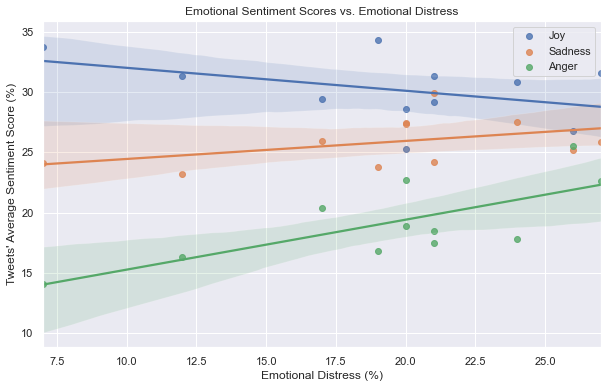

In [35]:
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
sns.set()
x = new_ed['Data']
plt.figure(figsize=(10,6))
sns.regplot(x, new_ed['Joy'], label ='Joy')
sns.regplot(x, new_ed['Sadness'], label ='Sadness')
sns.regplot(x, new_ed['Anger'], label ='Anger')

plt.xlabel('Emotional Distress (%)')
plt.ylabel("Tweets' Average Sentiment Score (%)")
plt.legend()
plt.title('Emotional Sentiment Scores vs. Emotional Distress')
plt.savefig('emod.png')

## Analysis

My hypothesis focused on the three main emotions—joy, sadness, and anger—and their correlation with mental health in high-income countries. To test my hypothesis, I first examined the mental health burden in high-income countries. According to the Commonwealth Fund, not every individual who experiences mental health symptoms goes to see a doctor. Therefore, self-reports of emotional distress may provide better insights into the actual mental health burden of the population. As defined by the Commonwealth Fund, “Emotional distress refers to adults who report they have experienced anxiety or great sadness which they found difficult to cope with by themselves in the past two years”.  Using the Commonwealth Fund’s data and my processed sentiment analysis for the eleven countries, I generated a scatter plot of emotion score percentages and the percentage of the population who self-reported experiencing emotional distress. As shown above, as the percentage of emotional distress in the population increases, the average joy score of Tweets decreases while the sadness and anger scores increase. This shows that there might be a moderate correlation between mental health and Tweet sentiments because those dealing with a mental health burden might be more pessimistic when expressing their thoughts. 

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



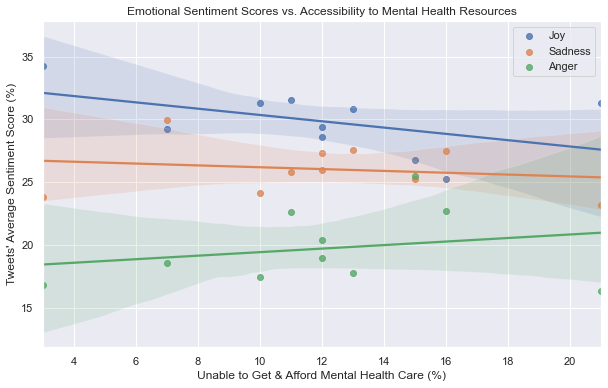

In [36]:
x = new_aff['Data']

plt.figure(figsize=(10,6))
sns.regplot(x, new_aff['Joy'], label ='Joy')
sns.regplot(x, new_aff['Sadness'], label ='Sadness')
sns.regplot(x, new_aff['Anger'], label ='Anger')
plt.xlabel('Unable to Get & Afford Mental Health Care (%)')
plt.ylabel("Tweets' Average Sentiment Score (%)")
plt.legend()
plt.title('Emotional Sentiment Scores vs. Accessibility to Mental Health Resources')
plt.savefig('acc_aff.png')

## Analysis

The access and affordability of professional mental health care are important factors in determining the mental health of a country. For those with mental health burdens, being able to afford and access professional help is vital. To analyze the correlation between sentiment scores and access to mental health care, I used the “Unable to Get or Afford Needed Mental Health Care” data from the Commonwealth Fund and plotted that with my processed data to generate the above figure. As shown above, when more emotionally distressed people are unable to get or afford help, joy and sadness scores decrease, and anger increases. This could mean that there is a weak correlation between mental health and Tweets’ average sentiment scores, because joy decreases and anger increases when less people have less access to professional mental health care. On the other hand, sadness’s trendline does not support the correlation because it has the same direction as joy, which was not expected. However, the slope of the sadness score trendline is low and the large confidence interval suggests a large enough variance in the data that precludes making a distinct conclusion. It might also be possible that people are less prone to sadness and are more irritated when they lack access to mental health care.


/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



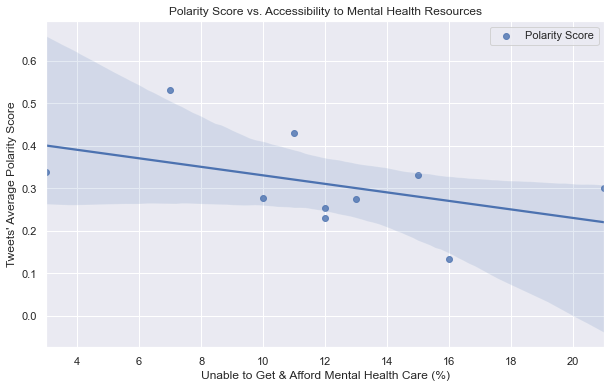

In [37]:
x = new_aff['Data']

plt.figure(figsize=(10,6))
sns.regplot(x, new_aff['Polarity Score'], label ='Polarity Score')
plt.xlabel('Unable to Get & Afford Mental Health Care (%)')
plt.ylabel("Tweets' Average Polarity Score")
plt.legend()
plt.title('Polarity Score vs. Accessibility to Mental Health Resources')
plt.savefig('acc_aff.png')

## Analysis

After analyzing the previous plots, I decided to do an additional analysis on the 'Emotional Sentiment Scores vs. Accessibility to Mental Health Resources' figure using countries’ trending topics average polarity score. The reason behind my choice for this topic is because lack of access to mental health care is a global issue and I believe that by studying it along with Tweets’ polarity scores, I can create meaningful discussions regarding access to mental health care. A Tweet’s polarity score shows how positive or negative that Tweet is with a lower score meaning more negative. As shown in the above figure, as the percentage of inaccessibility to mental health help increases, the countries’ Tweet’s average polarity scores decrease. This means that when less people have access to mental health care in high-income countries, their Tweets tend to be more negative. 




/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



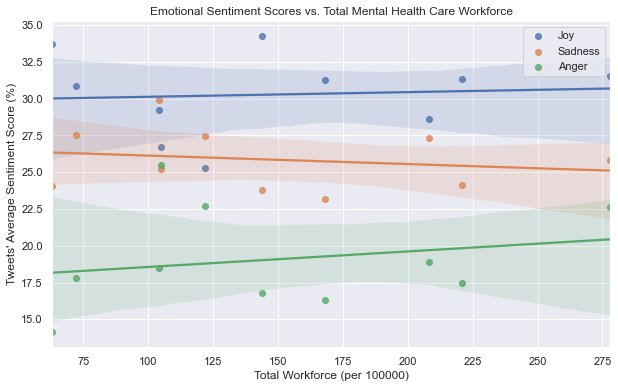

In [38]:
x = new_wf['Data']

plt.figure(figsize=(10,6))
sns.regplot(x, new_wf['Joy'], label ='Joy')
sns.regplot(x, new_wf['Sadness'], label ='Sadness')
sns.regplot(x, new_wf['Anger'], label ='Anger')
plt.xlabel('Total Workforce (per 100000)')
plt.ylabel("Tweets' Average Sentiment Score (%)")
plt.title('Emotional Sentiment Scores vs. Total Mental Health Care Workforce')
plt.legend()
plt.savefig('workforce.png')

## Analysis

Unmet mental health care needs could also be a result of a country’s limited professional mental health system. Therefore, I also looked at the mental health care capacity of each country, specifically, the total workforce supply. By plotting the number of total professionals working in the mental health sector, per 100,000 people, with my processed data, I generated the above figure. As shown in the figure, when there is a greater professional mental health care capacity available, the joy and anger scores increase and the sadness score decreases. This graph also supports a weak correlation between mental health and Tweets’ average sentiment scores, because it shows that joy has a positive trend and sadness has a negative trend with the total mental health care workforce, meaning the population is more optimistic when there is a greater professional mental health care presence. However, anger shows a positive trend with the total mental health care workforce.
